<a href="https://colab.research.google.com/github/AllanJosh/akj/blob/main/DATA_AUGMENTATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this notebook we tried to implement text augmentation

### Importing necessary libraries

In [ ]:
import re
import string
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import word_tokenize

from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Loading our dataset

import pandas as pd

file_path = '/content/drive/My Drive/Colab Notebooks/Airline Tweets.csv'
df = pd.read_csv(file_path)
df

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


## We dropped the rest of the columns and only work with data from the two columns that concerns us

In [ ]:
df = pd.read_csv(file_path, usecols=["text", "airline_sentiment"])
df

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
...,...,...
14635,positive,@AmericanAir thank you we got on a different f...
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,@AmericanAir Please bring American Airlines to...
14638,negative,"@AmericanAir you have my money, you change my ..."


## We obtained the avaerage sentence lenght of our 'text' column

In [ ]:
# Function to count words in a sentence
def count_words(text):
    if isinstance(text, str):
        return len(text.split())  # Split by spaces and count words
    return 0  # Return 0 if text is not a string (e.g., NaN values)

df['length_before_cleaning'] = df['text'].apply(count_words)
df

,airline_sentiment,text,length_before_cleaning
0,neutral,@VirginAmerica What @dhepburn said.,4
1,positive,@VirginAmerica plus you've added commercials t...,9
2,neutral,@VirginAmerica I didn't today... Must mean I n...,12
3,negative,@VirginAmerica it's really aggressive to blast...,17
4,negative,@VirginAmerica and it's a really big bad thing...,10
...,...,...,...
14635,positive,@AmericanAir thank you we got on a different f...,11
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...,23
14637,neutral,@AmericanAir Please bring American Airlines to...,7
14638,negative,"@AmericanAir you have my money, you change my ...",23


## The class Distribution for our dataset

In [ ]:
print("Initial Class Distribution:\n", df['airline_sentiment'].value_counts())


Initial Class Distribution:
 airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64


## Pre Processing Techniques

In [ ]:
# Some text cleaning functions
def convert_to_lower(text):
    return text.lower()

def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    removed = []
    stop_words = list(stopwords.words("english"))
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            removed.append(tokens[i])
    return " ".join(removed)

def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc


## Counting the number of words in each sentence after the preprocessing

In [ ]:
def count_words(text):
    if isinstance(text, str):
        return len(text.split())
    return 0  # Return 0 if text is not a string (e.g., NaN values)

df['length_after_cleaning'] = df['text'].apply(count_words)
df

,airline_sentiment,text,length_before_cleaning,length_after_cleaning
0,neutral,@VirginAmerica What @dhepburn said.,4,4
1,positive,@VirginAmerica plus you've added commercials t...,9,9
2,neutral,@VirginAmerica I didn't today... Must mean I n...,12,12
3,negative,@VirginAmerica it's really aggressive to blast...,17,17
4,negative,@VirginAmerica and it's a really big bad thing...,10,10
...,...,...,...,...
14635,positive,@AmericanAir thank you we got on a different f...,11,11
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...,23,23
14637,neutral,@AmericanAir Please bring American Airlines to...,7,7
14638,negative,"@AmericanAir you have my money, you change my ...",23,23


## We turn our airline sentiment into numerical values for easy reading by the machines. We introduced a new column called label that has our classes in numerical values

In [ ]:
label_map = {
    'neutral': 0,
    'positive': 1,
    'negative': -1,
}

df['label'] = df['airline_sentiment'].str.strip().str.lower().map(label_map)

df



,airline_sentiment,text,length_before_cleaning,length_after_cleaning,label
0,neutral,@VirginAmerica What @dhepburn said.,4,4,0
1,positive,@VirginAmerica plus you've added commercials t...,9,9,1
2,neutral,@VirginAmerica I didn't today... Must mean I n...,12,12,0
3,negative,@VirginAmerica it's really aggressive to blast...,17,17,-1
4,negative,@VirginAmerica and it's a really big bad thing...,10,10,-1
...,...,...,...,...,...
14635,positive,@AmericanAir thank you we got on a different f...,11,11,1
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...,23,23,-1
14637,neutral,@AmericanAir Please bring American Airlines to...,7,7,0
14638,negative,"@AmericanAir you have my money, you change my ...",23,23,-1


## We tranform our text into numbers/vectors using the TF-IDF Technique. The Term Frequency-Inverse Document Frequency

In [ ]:
tf_without_balancing = TfidfVectorizer()
X_tf_wob = tf_without_balancing.fit_transform(df['text'])
X_tf_wob = X_tf_wob.toarray()


In [ ]:
print(X_tf_wob.shape)
print(X_tf_wob)

(14640, 15051)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Splitting the Data into the Train and Testing Sets in preparation for model training

In [ ]:
# splitting dataset
X_train_tf_wob, X_test_tf_wob, y_train_tf_wob, y_test_tf_wob = train_test_split(X_tf_wob, df['label'].values, test_size=0.2)


## Applied a Logistic Regression model but with the data still in its row form in the unbalanced state

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_tf_wob, y_train_tf_wob)

y_pred = model.predict(X_test_tf_wob)

print("Accuracy on test set:", accuracy_score(y_test_tf_wob, y_pred))
print("Classification report:\n", classification_report(y_test_tf_wob, y_pred))


Accuracy on test set: 0.7967896174863388
Classification report:
               precision    recall  f1-score   support

          -1       0.82      0.94      0.87      1847
           0       0.65      0.50      0.57       592
           1       0.87      0.61      0.71       489

    accuracy                           0.80      2928
   macro avg       0.78      0.68      0.72      2928
weighted avg       0.79      0.80      0.79      2928



## Class Accuracies

## The Confusion Matrix

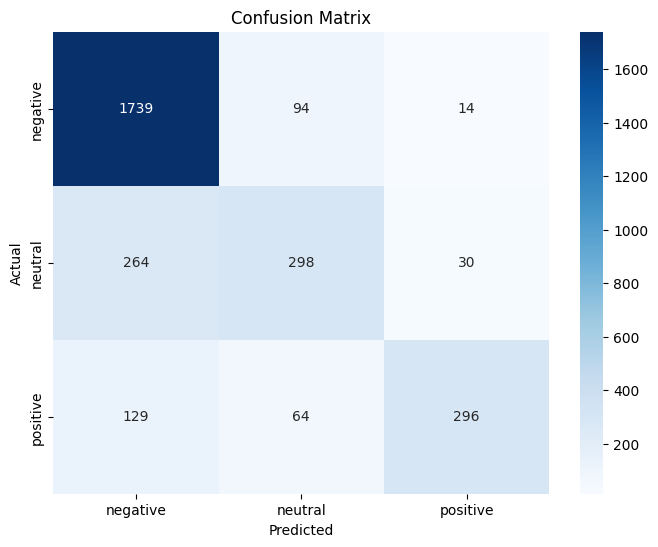

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test_tf_wob, y_pred)

# Define class labels if needed (for example, if -1=negative, 0=neutral, 1=positive)
class_labels = ['negative', 'neutral', 'positive']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Installing and Importing the libraries related to our data augmentation

In [ ]:
!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 6.4 MB/s eta 0:00:00


In [ ]:
import nlpaug.augmenter.word.context_word_embs as aug

## Using a BERT Pre trained model to augment our sentences

In [ ]:
augmenter = aug.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
sample_text = 'I love this university. The Professors are friendly and welcoming'

augmented_sample_text = augmenter.augment(sample_text)
augmented_sample_text

['god i love playing this university. and the professors are friendly here and welcoming']

## We now try to generate quite a number of augmented sentences for the same sentence

In [ ]:
for i in range(5):
    print(augmenter.augment(sample_text))

['i just love this campus university. the professors attending are friendly visitors and welcoming']
['i honestly love this university. the professors outside are friendly there and feel welcoming']
['and i love this school university. the professors are very friendly people and welcoming']
['seth i love this american university. the university professors upstairs are friendly and welcoming']
['i should love playing this university. the professors always are friendly and always welcoming']


## Our Class Distribution

In [ ]:
df['label'].value_counts()

,count
label,
-1,9178
0,3099
1,2363


# Now we augment our dataset

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.utils import shuffle

def augmentMyData(df, augmenter, repetitions=1, samples=200):
    synthetic_texts = []
    synthetic_labels = []

    # Process both minority classes: label 0 and label 1
    for label in [0, 1]:
        subset = df[df['label'] == label].reset_index(drop=True)

        for i in tqdm(np.random.randint(0, len(subset), samples), desc=f"Augmenting label {label}"):
            for _ in range(repetitions):
                augmented_text = augmenter.augment(subset['text'].iloc[i])

                # Ensure augmenter returns a string, not a list
                if isinstance(augmented_text, list):
                    augmented_text = augmented_text[0]

                synthetic_texts.append(augmented_text)
                synthetic_labels.append(label)

    # Create DataFrame for synthetic data with a 'synthetic' column
    synthetic_df = pd.DataFrame({
        'label': synthetic_labels,
        'text': synthetic_texts,
        'synthetic': True  # Mark as synthetic
    })

    # Mark original data as not synthetic
    df['synthetic'] = False  # Mark original data

    # Combine the original and synthetic data
    combined_df = pd.concat([df, synthetic_df], ignore_index=True)

    # Shuffle the combined DataFrame
    combined_df = shuffle(combined_df).reset_index(drop=True)

    return combined_df



## Once again removed the added columns counting the number of words in each sentence

In [ ]:
new_df = df.drop(labels=['length_before_cleaning', 'length_after_cleaning'], axis=1)
new_df

,airline_sentiment,text,label
0,neutral,@VirginAmerica What @dhepburn said.,0
1,positive,@VirginAmerica plus you've added commercials t...,1
2,neutral,@VirginAmerica I didn't today... Must mean I n...,0
3,negative,@VirginAmerica it's really aggressive to blast...,-1
4,negative,@VirginAmerica and it's a really big bad thing...,-1
...,...,...,...
14635,positive,@AmericanAir thank you we got on a different f...,1
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...,-1
14637,neutral,@AmericanAir Please bring American Airlines to...,0
14638,negative,"@AmericanAir you have my money, you change my ...",-1


## We augmented the data using this and it was able to generate as many new comments as possible- But we first tried out with 100 as a test

In [ ]:

aug_df = augmentMyData(new_df, augmenter, samples=100)

# Now, aug_df contains both original and synthetic data combined.


Augmenting label 1: 100%|██████████| 100/100 [02:07<00:00,  1.27s/it]


##  And then visualized the results in our work to see the effects
## Generated a Word Clouds for both synthetic and original data
## Then also the distribution of words in both the original and synthetic data

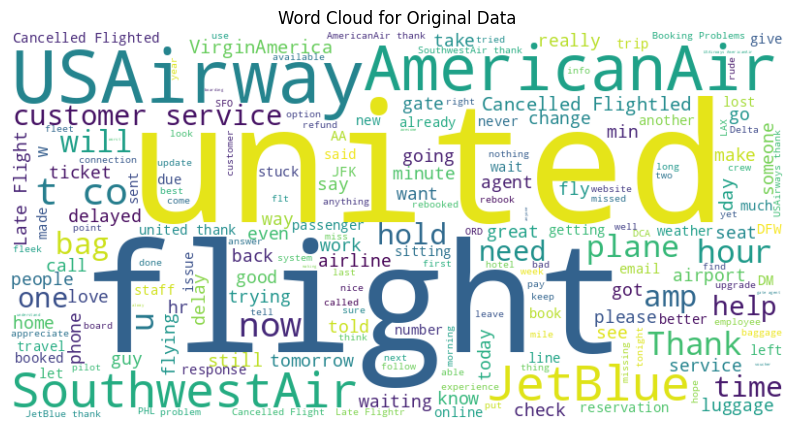

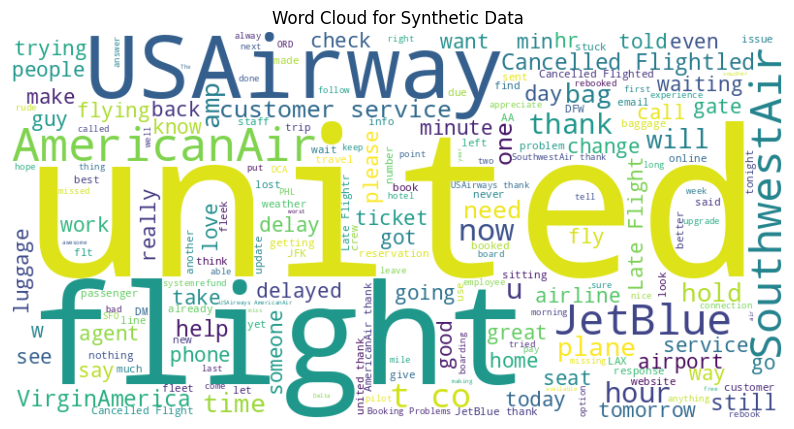

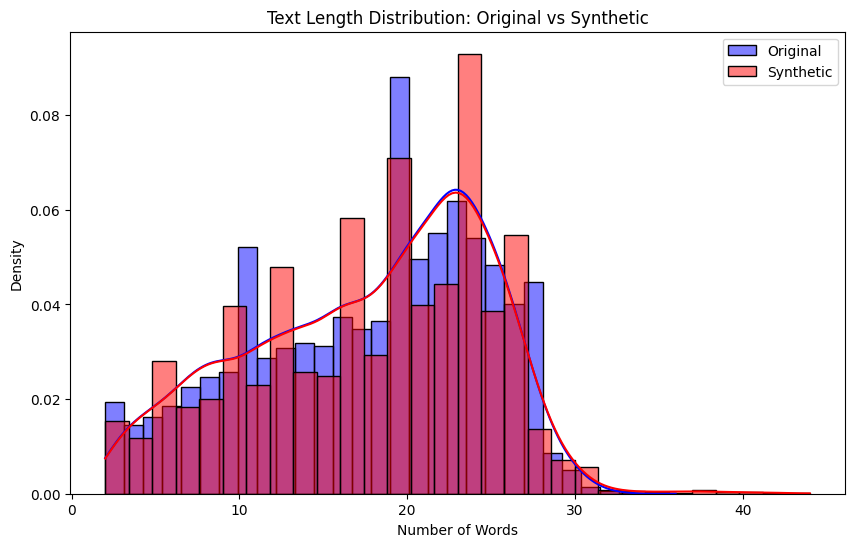

<ipython-input-41-20fa89781cb9>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=original_df, palette='Blues', alpha=0.7, label='Original')
<ipython-input-41-20fa89781cb9>:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=synthetic_df, palette='Reds', alpha=0.7, label='Synthetic')


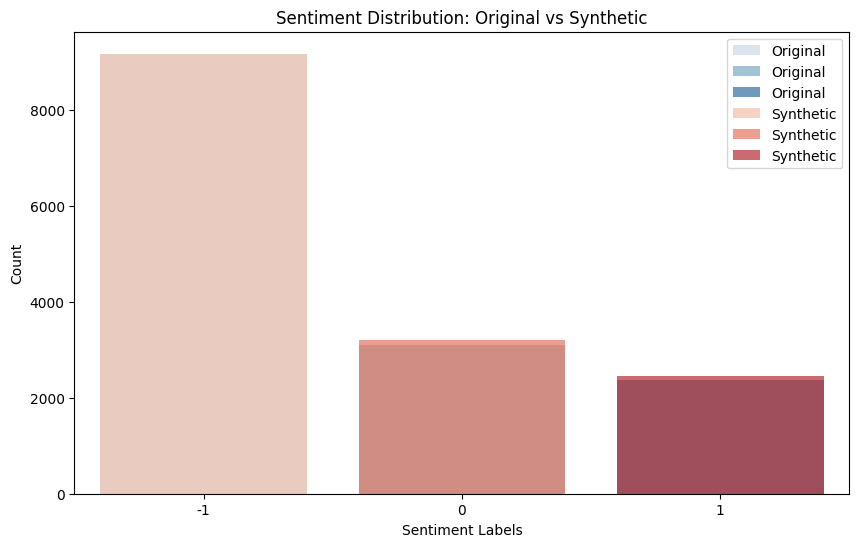

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# Step 1: Combine the original data and the augmented data
# Ensure that the synthetic data has a 'synthetic' column as True, and original as False
original_df = new_df
synthetic_df = aug_df

# Combine both original and synthetic data for visualizations
combined_df = pd.concat([original_df, synthetic_df], ignore_index=True)

# Step 2: Word Cloud Visualization
# Create a word cloud for the original data
plt.figure(figsize=(10, 6))
wordcloud_original = WordCloud(width=800, height=400, background_color='white').generate(" ".join(original_df['text']))
plt.imshow(wordcloud_original, interpolation='bilinear')
plt.title("Word Cloud for Original Data")
plt.axis('off')
plt.show()

# Create a word cloud for the synthetic data
plt.figure(figsize=(10, 6))
wordcloud_synthetic = WordCloud(width=800, height=400, background_color='white').generate(" ".join(synthetic_df['text']))
plt.imshow(wordcloud_synthetic, interpolation='bilinear')
plt.title("Word Cloud for Synthetic Data")
plt.axis('off')
plt.show()

# Step 3: Text Length Distribution Comparison
# Calculate the length of each text in the original and synthetic data
original_df['text_length'] = original_df['text'].apply(lambda x: len(x.split()))  # Word count
synthetic_df['text_length'] = synthetic_df['text'].apply(lambda x: len(x.split()))

# Plot distribution of text lengths for both datasets
plt.figure(figsize=(10, 6))
sns.histplot(original_df['text_length'], kde=True, color='blue', label='Original', stat='density', bins=30)
sns.histplot(synthetic_df['text_length'], kde=True, color='red', label='Synthetic', stat='density', bins=30)
plt.legend()
plt.title("Text Length Distribution: Original vs Synthetic")
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.show()

# Step 4: Sentiment Distribution Comparison
# Visualize sentiment distribution (label counts) in the original and synthetic data
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=original_df, palette='Blues', alpha=0.7, label='Original')
sns.countplot(x='label', data=synthetic_df, palette='Reds', alpha=0.7, label='Synthetic')
plt.title("Sentiment Distribution: Original vs Synthetic")
plt.xlabel("Sentiment Labels")
plt.ylabel("Count")
plt.legend()
plt.show()

# Optional: You can also visualize other statistics like character length, etc.


## Displaying the first few sentences from the Synthetic dataset

In [ ]:

print("Some sentences from the synthetic data:\n")
synthetic_df[['label', 'text']].head(10)



Some sentences from the synthetic data:



,label,text
0,0,@SouthwestAir : thanks.are flights operating n...
1,-1,@SouthwestAir where was the inclement weather?...
2,1,@JetBlue I do! The best airline wifi ever. Tha...
3,-1,@AmericanAir should reconsider #usairways acqu...
4,0,@united question. Are departure times based of...
5,-1,@united Usually an issue with Express our of S...
6,1,“@united: @d_goodspeed We will follow up with ...
7,1,@SouthwestAir big thanks to your team. family ...
8,-1,@USAirways nothing important to do. Why was I...
9,-1,@united Learn to hold connections. They texted...


## Then we randomly selected 5 senteces to still display

In [ ]:

print("\nRandom sentences from the synthetic data:\n")
synthetic_df[['label', 'text']].sample(5)



Random sentences from the synthetic data:



,label,text
7798,-1,@USAirways this is my 2nd attempt to call US a...
4666,1,@USAirways Thanks!
7249,-1,@AmericanAir Trying to get my flight changed t...
2261,-1,"@JetBlue Hey Jetblue, you stranded an entire p..."
8689,-1,@USAirways my vacation budget was blown bc of ...


# Since we saw that it works, now we applied it on all the entire datset on the classes with few samples. And generate now for the entire dataset

In [ ]:
# Augment data using the function, here I'm calling it once for the samples
aug_df = augmentMyData(new_df, augmenter, samples=6000)

# Now, aug_df contains both original and synthetic data combined.


Augmenting label 0:   0%|          | 2/6000 [00:02<2:16:22,  1.36s/it]


KeyboardInterrupt: 

In [ ]:
combined_df['label'].value_counts()

,count
label,
-1,18356
0,6298
1,4826


## Since the code generated very many synthetic reviews, we try to make sure that we maintain the original negative reviews, then only fill up the positive and neutral to make sure that they have the same number as the negative ones

In [ ]:

original_negatives = combined_df[combined_df['label'] == -1].sample(n=9178, random_state=42)

# Separating synthetic and original data for labels 0 and 1
original_0 = combined_df[(combined_df['label'] == 0) & (combined_df['synthetic'] == False)]
original_1 = combined_df[(combined_df['label'] == 1) & (combined_df['synthetic'] == False)]

synthetic_0 = combined_df[(combined_df['label'] == 0) & (combined_df['synthetic'] == True)]
synthetic_1 = combined_df[(combined_df['label'] == 1) & (combined_df['synthetic'] == True)]

# Keeping  only the needed synthetic samples
needed_synthetic_0 = synthetic_0.sample(n=(9178 - len(original_0)), random_state=42)
needed_synthetic_1 = synthetic_1.sample(n=(9178 - len(original_1)), random_state=42)

# Recombining  everything correctly
fixed_df = pd.concat([original_negatives, original_0, original_1, needed_synthetic_0, needed_synthetic_1], ignore_index=True)

# Shuffling  the final dataset
fixed_df = shuffle(fixed_df).reset_index(drop=True)

# Checking  the fixed distribution
print(fixed_df['label'].value_counts())


# Because the code runs for long, I saved the file as a csv file so that I dont have to regenerate the synthetic comments once more

In [ ]:
# Save fixed_df to CSV
fixed_df.to_csv('fixed_df.csv', index=False)


In [ ]:
# Save to a specific directory
fixed_df.to_csv('/content/drive/My Drive/Colab Notebooks/fixed_df.csv', index=False)


# NOw this is our loaded balanced file of reviews now which we can maybe use to do analysis

In [45]:
# Load fixed_df from CSV
fixed_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/fixed_df.csv')
fixed_df

,airline_sentiment,text,label,synthetic,text_length
0,negative,jetblue i just booked a flight with you guys i...,0,False,18.0
1,neutral,united thank you for the quick response but i ...,1,False,18.0
2,positive,americanair no apology necessary it was wind a...,2,False,13.0
3,positive,united 4 reflight booking problemss in last 2 ...,2,False,25.0
4,negative,americanair would love to dm you but my twitte...,0,False,18.0
...,...,...,...,...,...
27529,NaN,usairways online thank you usairways your orig...,2,True,NaN
27530,positive,united sorry to hear outsourcing plan boise is...,2,False,15.0
27531,positive,southwestair i just had a great experience wit...,2,False,17.0
27532,positive,jetblue would you say a delay is more likely t...,2,False,12.0


## Now we run the same analysis on this new combines and balanced dataset

In [48]:
from sklearn.utils import shuffle

# Ensuring that fixed_df is properly shuffled
fixed_df = shuffle(fixed_df).reset_index(drop=True)


print("Label Counts:\n", fixed_df['label'].value_counts())
print("\nMissing Text Values:", fixed_df['text'].isnull().sum())
print("\nEmpty Strings Count:", (fixed_df['text'].str.strip() == "").sum())

# Missing values
fixed_df = fixed_df.dropna(subset=['text'])
fixed_df = fixed_df[fixed_df['text'].str.strip() != ""]

Label Counts:
 label
1    9178
2    9178
0    9178
Name: count, dtype: int64

Missing Text Values: 0

Empty Strings Count: 0


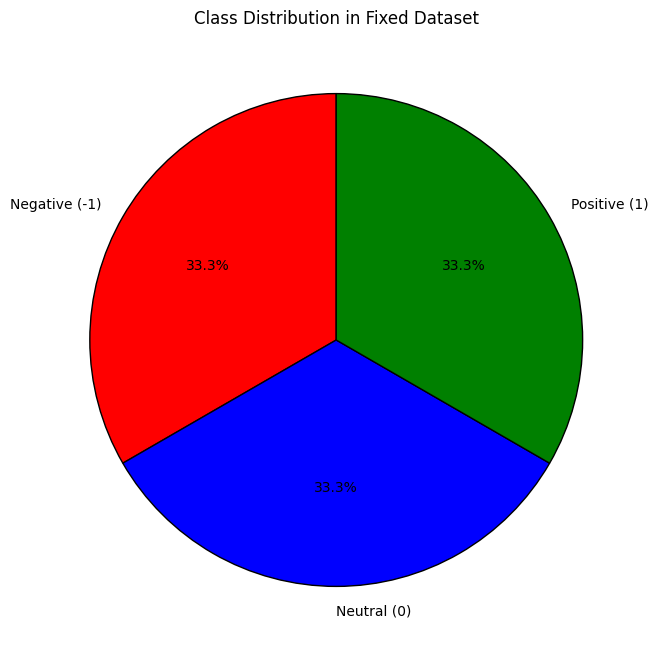

In [52]:
# Pie Chart for Class Distribution
plt.figure(figsize=(8, 8))
fixed_df['label'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    colors=['red', 'blue', 'green'],
    labels=['Negative (-1)', 'Neutral (0)', 'Positive (1)'],
    wedgeprops={'edgecolor': 'black'}
)
plt.title("Class Distribution in Fixed Dataset")
plt.ylabel("")  # Remove y-label for better visualization
plt.show()




## Word Cloud Analysis

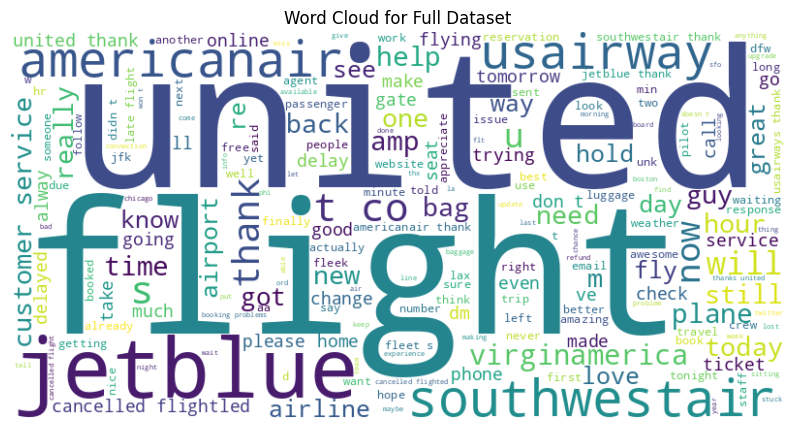

Skipping Word Cloud for Negative Class: No data available.


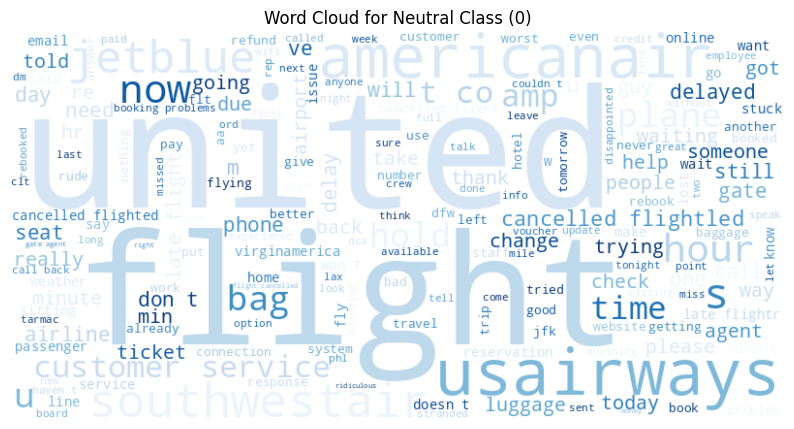

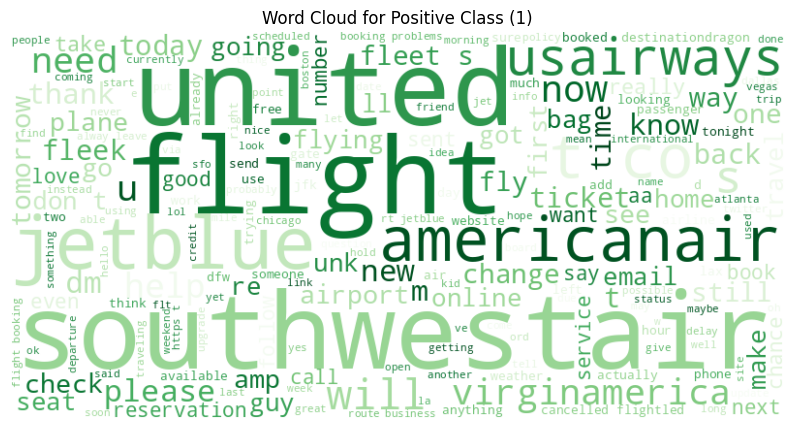

In [49]:

def generate_wordcloud(data, title, colormap="viridis"):
    """Generate and display a word cloud."""
    text = " ".join(data['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=colormap).generate(text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# General Word Cloud
generate_wordcloud(fixed_df, "Word Cloud for Full Dataset", colormap="viridis")

# Word Clouds by Label (Check for empty subsets)
for label, colormap, label_name in [(-1, "Reds", "Negative"), (0, "Blues", "Neutral"), (1, "Greens", "Positive")]:
    subset = fixed_df[fixed_df['label'] == label]

    if subset.empty or subset['text'].isnull().all():
        print(f"Skipping Word Cloud for {label_name} Class: No data available.")
    else:
        generate_wordcloud(subset, f"Word Cloud for {label_name} Class ({label})", colormap)


## Text Length Distribution

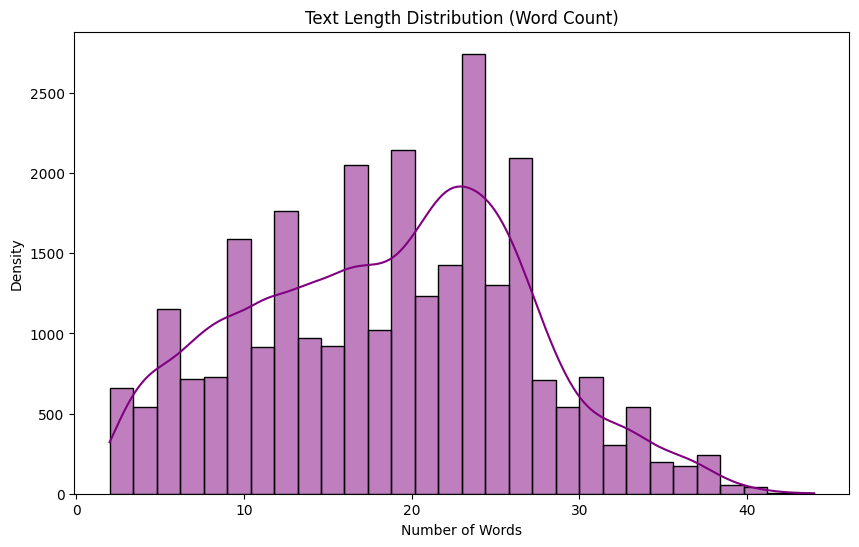

<ipython-input-50-2f5816cd60de>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="label", y="text_length", data=fixed_df, palette="coolwarm")


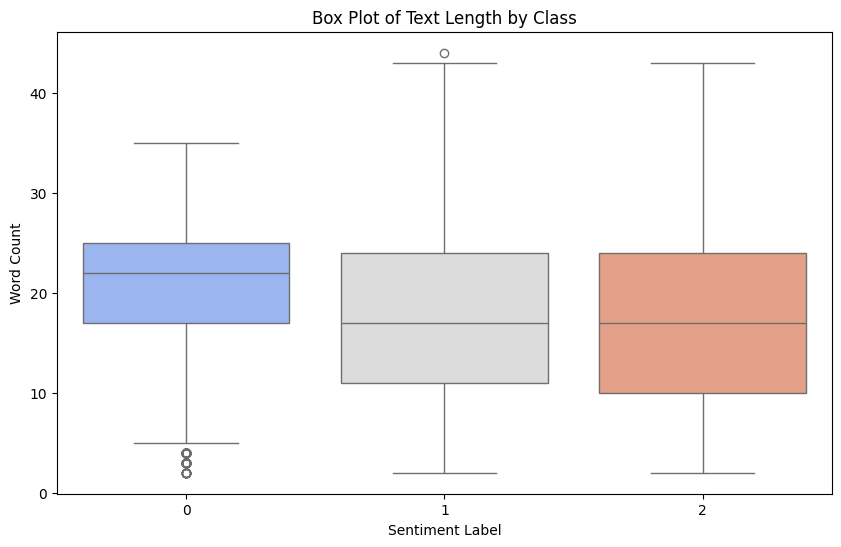

In [50]:

fixed_df['text_length'] = fixed_df['text'].apply(lambda x: len(x.split()))

# Histogram of Text Length
plt.figure(figsize=(10, 6))
sns.histplot(fixed_df['text_length'], kde=True, bins=30, color="purple")
plt.title("Text Length Distribution (Word Count)")
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.show()

# Box Plot of Text Length per Label
plt.figure(figsize=(10, 6))
sns.boxplot(x="label", y="text_length", data=fixed_df, palette="coolwarm")
plt.title("Box Plot of Text Length by Class")
plt.xlabel("Sentiment Label")
plt.ylabel("Word Count")
plt.show()

## Synthetic Vs Original

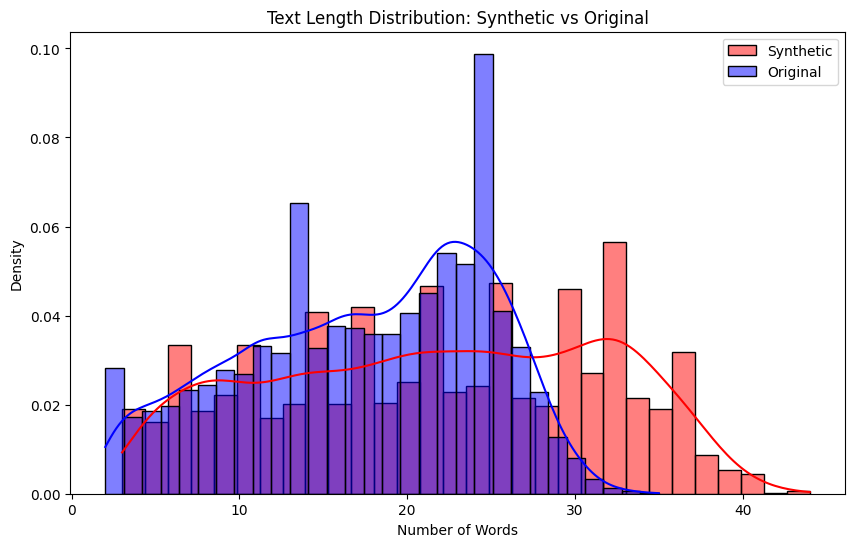

<ipython-input-55-9fd20fbccd80>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="synthetic", y="text_length", data=fixed_df, palette="coolwarm")


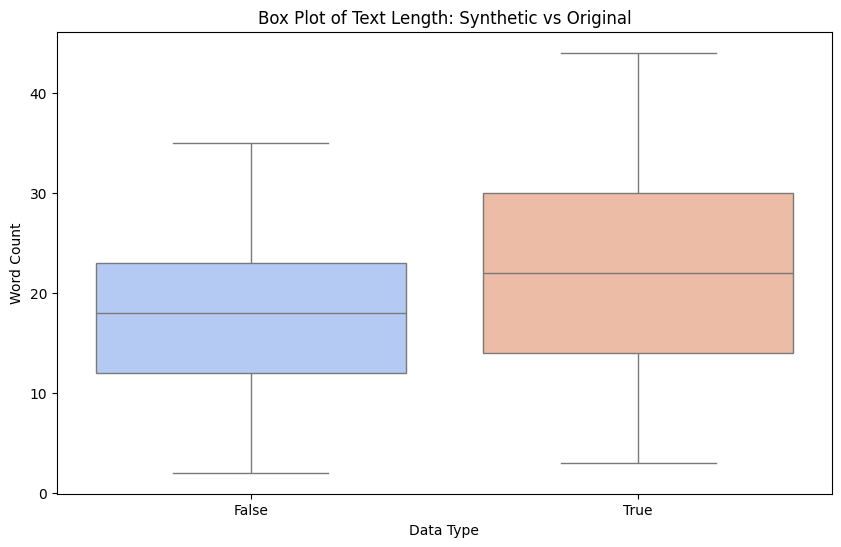

In [55]:

fixed_df['synthetic'] = fixed_df['synthetic'].astype(str)

# Distribution of Text Length for Synthetic vs Original
plt.figure(figsize=(10, 6))
sns.histplot(fixed_df[fixed_df['synthetic'] == "True"]['text_length'], kde=True, color='red', label='Synthetic', bins=30, stat="density")
sns.histplot(fixed_df[fixed_df['synthetic'] == "False"]['text_length'], kde=True, color='blue', label='Original', bins=30, stat="density")
plt.legend()
plt.title("Text Length Distribution: Synthetic vs Original")
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.show()




# Box Plot of Text Length for Synthetic vs Original
plt.figure(figsize=(10, 6))
sns.boxplot(x="synthetic", y="text_length", data=fixed_df, palette="coolwarm")
plt.title("Box Plot of Text Length: Synthetic vs Original")
plt.xlabel("Data Type")
plt.ylabel("Word Count")
plt.show()

## Text length

<ipython-input-56-0554999d99f1>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_text_length.index, y=mean_text_length.values, palette="coolwarm")


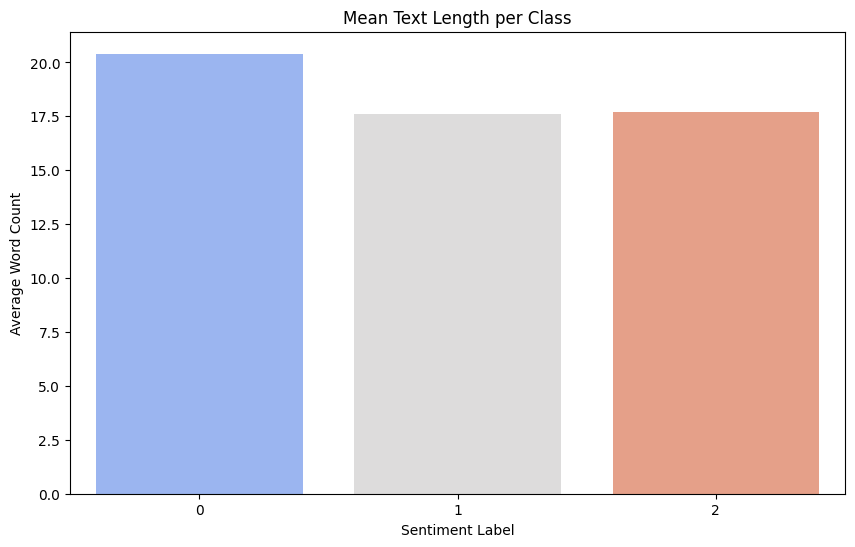

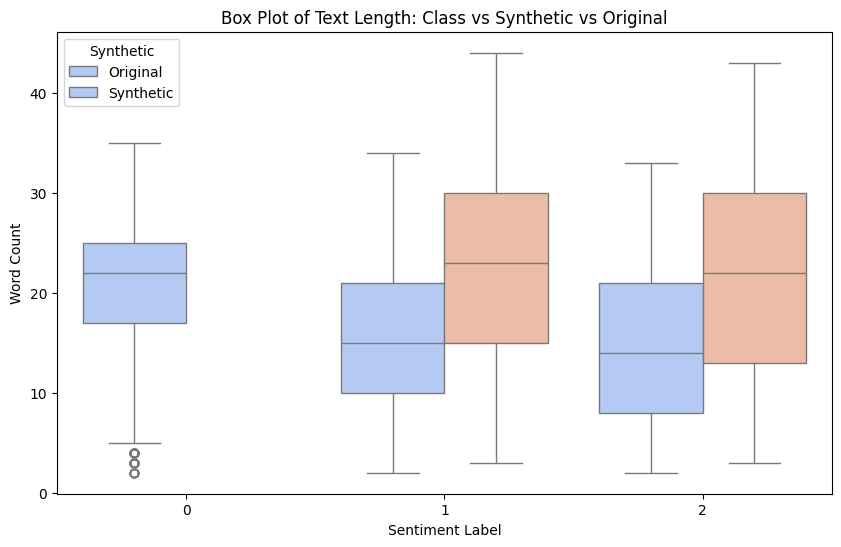

In [56]:



# Comparing Mean Text Length per Class
mean_text_length = fixed_df.groupby("label")["text_length"].mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_text_length.index, y=mean_text_length.values, palette="coolwarm")
plt.title("Mean Text Length per Class")
plt.xlabel("Sentiment Label")
plt.ylabel("Average Word Count")
plt.show()

# Box Plot of Text Length by Class & Synthetic
plt.figure(figsize=(10, 6))
sns.boxplot(x="label", y="text_length", hue="synthetic", data=fixed_df, palette="coolwarm")
plt.title("Box Plot of Text Length: Class vs Synthetic vs Original")
plt.xlabel("Sentiment Label")
plt.ylabel("Word Count")
plt.legend(title="Synthetic", labels=["Original", "Synthetic"])
plt.show()
